# Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import cv2
import os
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.utils import plot_model

2024-02-08 09:28:21.827855: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-08 09:28:21.827988: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-08 09:28:21.961164: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Exploring Dataset

In [2]:
# Image Paths
train_path = '/kaggle/input/wildfirev1/train'
val_path = '/kaggle/input/wildfirev1/valid'
test_path = '/kaggle/input/wildfirev1/test'

# Annotations Paths
train_annot = pd.read_csv('/kaggle/input/wildfirev1/train/_annotations.csv')
valid_annot = pd.read_csv('/kaggle/input/wildfirev1/valid/_annotations.csv')
test_annot = pd.read_csv('/kaggle/input/wildfirev1/test/_annotations.csv')

In [3]:
# Overview of annot.csv
train_annot.head(5)

,filename,width,height,class,xmin,ymin,xmax,ymax
0,ck0qd8gs6ko7j0721x25cv4o3_jpeg.rf.005f5707706e...,640,480,smoke,125,190,177,286
1,ck0t40rhdz68s0a46ekx049a6_jpeg.rf.00403179fe5f...,640,480,smoke,326,207,494,249
2,ck0m0ch9ugnna07940o8x989j_jpeg.rf.0101cdb46a16...,640,480,smoke,308,166,582,257
3,ck0rr6bfa9b3w0721aw5unwdy_jpeg.rf.00982c053d66...,640,480,smoke,241,204,310,244
4,ck0uk75x5ysls0721e5a9j891_jpeg.rf.00d7fd8503e1...,640,480,smoke,523,208,619,288


In [4]:
def Bounding_box(image, annotations):
    
    for index, row in annotations.iterrows():
        
        print(row)
        x1 = int(row["xmin"])
        y1 = int(row["ymin"])
        x2 = int(row["xmax"])
        y2 = int(row["ymax"])
        label = row["class"]

        cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
        cv2.putText(image, label, (x1, y1-5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

    return image

(480, 640, 3)
filename    ck0rql046icek0a462kapdu97_jpeg.rf.61cb5eb5e971...
width                                                     640
height                                                    480
class                                                   smoke
xmin                                                        2
ymin                                                      256
xmax                                                      154
ymax                                                      333
Name: 25, dtype: object


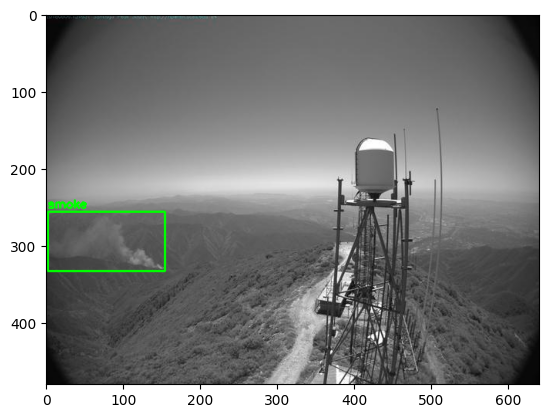

In [5]:
for i in os.listdir(test_path)[1:]:
    
    img = cv2.imread(os.path.join(test_path, i), cv2.IMREAD_COLOR)
    print(img.shape)
    image_annotations = test_annot[test_annot['filename'] == i]
    
    annotated_image = Bounding_box(img, image_annotations)
    
    plt.imshow(annotated_image)
    break

# Creating inputs


In [6]:
input_size = (100, 100)
def load_data(directory):
    annots = pd.read_csv(os.path.join(directory, '_annotations.csv'))
    images = []
    boundingBoxes = []
    for index, row in annots.iterrows():
        img = cv2.imread(os.path.join(directory, row['filename']), 0)
        try:
            resized_img = cv2.resize(img, input_size)
            x = resized_img/255.0
            images.append(x)
            
            bounds = [row['xmin']/row['width'], row['ymin']/row['height'], 
                      row['xmax']/row['width'], row['ymax']/row['height']]
            boundingBoxes.append(bounds)
        except:
            continue
            
    return np.array(images), np.array(boundingBoxes, dtype=np.float32) 

In [7]:
X_train, y_train = load_data(train_path)

In [8]:
X_valid, y_valid = load_data(val_path)

In [9]:
X_test, y_test = load_data(test_path)

# Model Building

In [10]:
class Model:
    
    def __init__(self, inputs):
        
        self.inputs = inputs
        self.feature_extractor = self.build_feature_extractor()
        self.model_adaptor = self.build_model_adaptor(self.feature_extractor)
        self.regressor_head = self.build_regressor_head(self.model_adaptor)
        
    def build_feature_extractor(self):
        x = tf.keras.layers.Conv2D(32, kernel_size = (3, 3), activation='relu', input_shape=(100, 100, 1))(self.inputs)
        x = tf.keras.layers.AveragePooling2D(2,2)(x)
        
        x = tf.keras.layers.Conv2D(32, kernel_size=3, activation = 'relu')(x)
        x = tf.keras.layers.AveragePooling2D(2,2)(x)

        x = tf.keras.layers.Conv2D(64, kernel_size=3, activation = 'relu')(x)
        x = tf.keras.layers.AveragePooling2D(2,2)(x)
        
        return x
    
    def build_model_adaptor(self, inputs):
        
        x = tf.keras.layers.Flatten()(inputs)
        x = tf.keras.layers.Dense(64, activation='relu')(x)
        
        return x

    def build_regressor_head(self, inputs):
        x = tf.keras.layers.Dense(units = '4', name = 'regressor_head')(inputs)
        return x                    
    
    def build_model(self):
        
        model = tf.keras.Model(inputs = self.inputs, outputs=[self.regressor_head])
        return model

In [11]:
model = Model(tf.keras.layers.Input(shape=(100, 100, 1, )))

model = model.build_model()

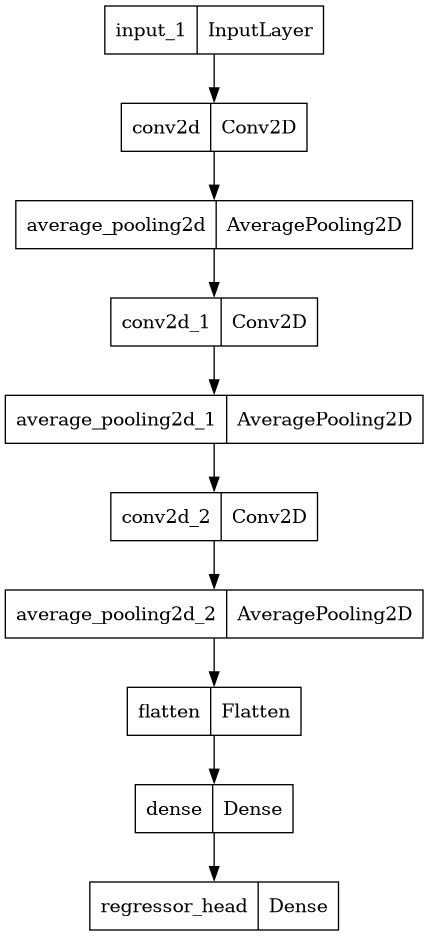

In [12]:
plot_model(model, 'model.png')

In [13]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), 
              loss='mean_squared_error', 
              metrics='mse')

In [14]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    patience = 15,
    restore_best_weights = True,
    verbose = 1,
    min_delta = 0.001,
)

In [15]:
EPOCHS = 100
BATCH_SIZE = 32

In [16]:
history = model.fit(X_train, y_train,
          validation_data = (X_valid, y_valid),
          callbacks = [early_stopping],
          batch_size = BATCH_SIZE,
          epochs = EPOCHS)

Epoch 1/100


I0000 00:00:1707384525.996490      70 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


17/17 [==============================] - 5s 41ms/step - loss: 0.0615 - mse: 0.0615 - val_loss: 0.0586 - val_mse: 0.0586
Epoch 2/100
17/17 [==============================] - 0s 8ms/step - loss: 0.0608 - mse: 0.0608 - val_loss: 0.1471 - val_mse: 0.1471
Epoch 3/100
17/17 [==============================] - 0s 8ms/step - loss: 0.0570 - mse: 0.0570 - val_loss: 0.2370 - val_mse: 0.2370
Epoch 4/100
17/17 [==============================] - 0s 8ms/step - loss: 0.0320 - mse: 0.0320 - val_loss: 0.0443 - val_mse: 0.0443
Epoch 5/100
17/17 [==============================] - 0s 8ms/step - loss: 0.0366 - mse: 0.0366 - val_loss: 0.1213 - val_mse: 0.1213
Epoch 6/100
17/17 [==============================] - 0s 8ms/step - loss: 0.0432 - mse: 0.0432 - val_loss: 0.1330 - val_mse: 0.1330
Epoch 7/100
17/17 [==============================] - 0s 8ms/step - loss: 0.0387 - mse: 0.0387 - val_loss: 0.0407 - val_mse: 0.0407
Epoch 8/100
17/17 [==============================] - 0s 8ms/step - loss: 0.1087 - mse: 0.1087 

In [17]:
history_df = pd.DataFrame(history.history)

In [18]:
model.evaluate(X_test, y_test)

3/3 [==============================] - 0s 55ms/step - loss: 0.0385 - mse: 0.0385


[0.038544122129678726, 0.038544122129678726]

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


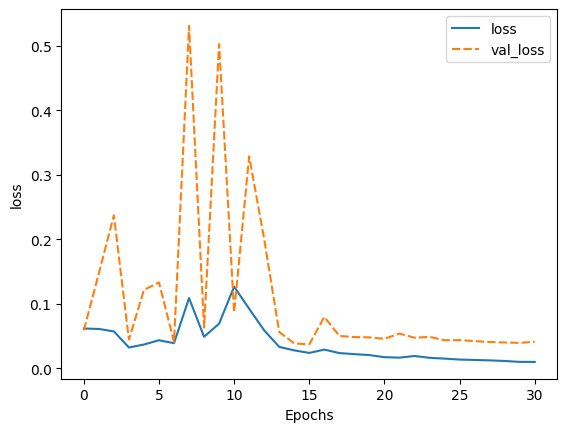

In [19]:
sns.lineplot(data = history_df.loc[:, ['loss', 'val_loss']])
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.show()

# Predicting Testing image

In [20]:
y_pred = model.predict(X_test)

3/3 [==============================] - 0s 3ms/step


In [21]:
model.evaluate(X_test, y_test)

3/3 [==============================] - 0s 4ms/step - loss: 0.0385 - mse: 0.0385


[0.038544122129678726, 0.038544122129678726]

In [22]:
print(y_pred[0], y_test[0])

[0.580522   0.3957671  0.8315142  0.54017377] [0.803125   0.43541667 0.9625     0.59375   ]


In [23]:
x1, x2, y1, y2 = y_pred[0]

In [24]:
x1, x2, y1, y2 = y_test[0]

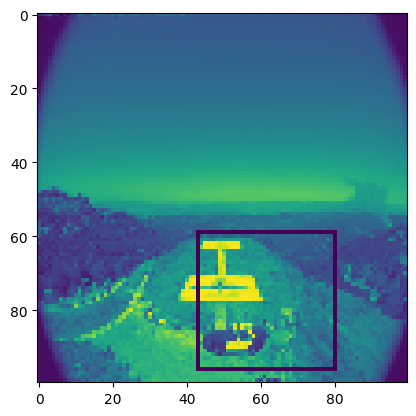

In [25]:
img = X_test[0]
height, width = img.shape
cv2.rectangle(img, (int(x1*width), int(y1*height)), (int(x2*width), int(y2*height)), (0, 255, 0), 1)
plt.imshow(img)